In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans

In [17]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [23]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [32]:
train = pd.read_csv('C:/Users/Playdata/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/Playdata/Desktop/전력수요예측/test.csv')

In [ ]:
##### train 결측치 채우기

In [33]:
for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [34]:
for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중


In [35]:
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

In [38]:
train_sample = train['2018-02-15':]
train_sample = train_sample.interpolate(method='time')

test_sample = test['2018-02-15':]
test_sample = test_sample.interpolate(method='time')

In [39]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

Index(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'],
      dtype='object')

In [41]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

Index(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],
      dtype='object')

In [42]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],axis=1,inplace=True)

In [47]:
train_sample

,X692,X1272,X553,X1299,X598,X1003,X1010,X1216,X1047,X381,X466,X1420,X686,X711,X1251,X828,X1350,X1066,X1293,X1148,X451,X174,X74,X626,X1083,X1000,X632,X1380,X607,X680,X977,X492,X968,X891,X122,X489,X86,X392,X1007,X549,X1343,X437,X551,X287,X138,X339,X1210,X644,X1472,X604,...,X1166,X1431,X1482,X441,X1070,X707,X493,X785,X873,X1179,X1125,X109,X224,X1259,X1143,X1324,X889,X689,X447,X1270,X827,X1037,X942,X1498,X678,X1100,X239,X1369,X436,X536,X933,X1035,X1194,X1441,X291,X1328,X1323,X616,X1195,X944,X1017,X1164,X656,X1287,X324,X767,X1271,X1288,X1033,X1163
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-15 00:00:00,0.150000,0.392000,0.181000,0.237000,0.064000,0.231000,0.253000,0.289000,0.107000,0.134000,0.257000,0.236000,0.236000,0.112000,0.135000,0.659000,0.150000,0.058000,0.260000,0.128000,0.044000,0.694000,0.000009,0.09500,0.125000,0.226000,0.242000,0.29300,0.147000,0.333000,0.128000,0.069000,0.300000,0.1770,0.005,0.063000,0.249,0.317000,0.202000,0.271000,0.207000,0.167000,0.165000,0.382000,0.247,0.137000,0.003000,0.104000,0.259000,0.151000,...,0.253000,0.189000,0.352000,0.19400,0.225000,0.201000,0.074000,0.099000,0.0040,0.225000,0.089000,0.088,0.376000,0.152000,0.385000,0.158000,0.1340,0.205000,0.098000,0.395000,0.297000,0.235000,0.3060,0.251000,0.161000,0.146000,0.784000,0.396000,0.006000,0.234000,0.2780,0.155000,0.058000,0.218000,0.371000,0.193000,0.240000,0.351000,0.132000,0.637000,0.219000,0.6940,0.113000,0.096000,0.053000,0.282000,0.200000,0.305000,0.148000,0.136000
2018-02-15 01:00:00,0.422000,0.873000,0.502000,0.356000,0.160000,0.365000,0.406000,0.267000,0.209000,0.180000,0.271000,0.453000,0.636000,0.361000,0.289000,0.566000,0.336000,0.130000,0.390000,0.286000,0.107000,0.783000,0.000009,0.29900,0.241000,0.448000,0.473000,0.54900,0.260000,0.653000,0.214000,0.157000,0.703000,0.4420,0.006,0.152000,0.315,0.241000,0.564000,0.383000,0.308000,0.249000,0.205000,0.298000,0.200,0.345000,0.007000,0.125000,0.582000,0.329000,...,0.481000,0.482000,0.887000,0.42900,0.285000,0.318000,0.267000,0.232000,0.0170,0.437000,0.141000,0.101,0.250000,0.328000,0.805000,0.327000,0.4350,0.425000,0.217000,0.822000,0.295000,0.411000,0.4490,0.337000,0.349000,0.297000,0.667000,0.866000,0.014000,0.419000,0.4750,0.376000,0.242000,0.697000,0.213000,0.224000,0.304000,1.495000,0.334000,0.677000,0.647000,0.6770,0.226000,0.338000,0.138000,0.391000,0.168000,0.371000,0.322000,0.215000
2018-02-15 02:00:00,0.314000,0.440000,0.461000,0.308000,0.174000,0.341000,0.400000,0.279000,0.192000,0.281000,0.182000,0.336000,0.464000,0.497000,0.299000,0.561000,0.331000,0.198000,0.336000,0.263000,0.088000,0.643000,0.000009,0.15700,0.229000,0.394000,0.496000,0.61900,0.246000,0.420000,0.246000,0.241000,0.689000,0.3760,0.006,0.161000,0.252,0.221000,0.472000,0.341000,0.340000,0.284000,0.185000,0.241000,0.112,0.256000,0.011000,0.164000,0.562000,0.298000,...,0.476000,0.357000,0.531000,0.41700,0.199000,0.143000,0.205000,0.238000,0.0170,0.428000,0.129000,0.088,0.154000,0.282000,0.657000,0.272000,0.6870,0.354000,0.185000,0.766000,0.228000,0.430000,0.3390,0.331000,0.361000,0.295000,0.670000,0.643000,0.015000,0.197000,0.3470,0.311000,0.274000,0.318000,0.213000,0.119000,0.239000,0.859000,0.246000,0.496000,0.530000,0.6560,0.219000,0.222000,0.094000,0.355000,0.149000,0.390000,0.347000,0.135000
2018-02-15 03:00:00,0.309000,0.292000,0.524000,0.279000,0.198000,0.343000,0.393000,0.272000,0.142000,0.295000,0.207000,0.330000,0.211000,0.368000,0.292000,0.553000,0.355000,0.148000,0.316000,0.251000,0.101000,0.635000,0.000009,0.14500,0.272000,0.372000,0.314000,0.48400,0.220000,0.390000,0.235000,0.250000,0.729000,0.3970,0.005,0.152000,0.250,0.208000,0.398000,0.334000,0.353000,0.284000,0.163000,0.209000,0.136,0.268000,0.007000,0.115000,0.543000,0.313000,...,0.506000,0.365000,0.489000,0.33200,0.155000,0.153000,0.174000,0.273000,0.0150,0.465000,0.131000,0.102,0.177000,0.265000,0.572000,0.224000,0.2180,0.321000,0.183000,0.798000,0.232000,0.428000,0.3

In [185]:
ss = pd.concat([train_sample,test_sample], axis=1)

In [186]:
formatted = to_time_series_dataset(ss.values.reshape(3264,1429,1))

In [247]:
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(formatted)

201.027 --> 138.299 --> 135.430 --> 134.568 --> 133.933 --> 133.150 --> 132.455 --> 131.955 --> 131.770 --> 131.575 --> 131.454 --> 131.362 --> 131.302 --> 131.269 --> 131.261 --> 131.258 --> 131.257 --> 131.257 --> 


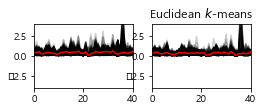

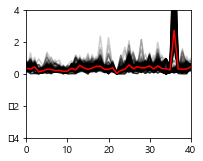

In [252]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in formatted[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 40)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        plt.figure(figsize=(10, 8))

In [ ]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
# print("DBA k-means")
# dba_km = TimeSeriesKMeans(n_clusters=3,
#                           n_init=2,
#                           metric="dtw",
#                           verbose=True,
#                           max_iter_barycenter=10,
#                           random_state=seed)
# y_pred = dba_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 4 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     if yi == 1:
#         plt.title("DBA $k$-means")

# # Soft-DTW-k-means
# print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=3,
#                            metric="softdtw",
#                            metric_params={"gamma_sdtw": .01},
#                            verbose=True,
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 7 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")

# plt.tight_layout()
# plt.show()